<a href="https://colab.research.google.com/github/kakafune2323/MTS_basicML/blob/main/HW_%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание на мультиколлинеарность в ансамблях деревьев

Сегодня в домашнем задании вместе с вами разберем популярный миф что мультиколлинеарность фичей никак не аффектит алгоритмы, основанные на ансамблях деревьев

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import math

rng = np.random.default_rng(seed=121)
random_state = 121
n_features = 10
n_samples = 20_000

# создадим датасет для классификации
x, y = make_classification(n_samples=n_samples, random_state=random_state, n_features=n_features)
df = pd.DataFrame(x, columns=[f'feature_{k}' for k in range(n_features)])
df['target'] = y

Введем пару фичей с мультиколлинеарностью

In [2]:
df['golden_feature_1'] = df['target'] + rng.normal(size = len(y), scale = 0.4) # здесь шума добавили побольше -- фича будет послабее
df['golden_feature_2'] = df['target'] + df['golden_feature_1']  + rng.normal(size = len(y), scale = 0.35)#  здесь шума добавили поменьше -- фича будет посильнее

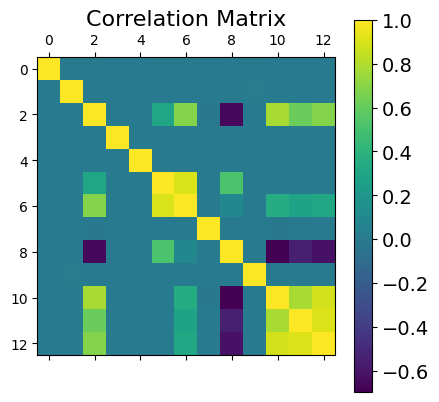

In [3]:
import matplotlib.pyplot as plt

plt.matshow(df.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Посмотрим на правый нижний квадрат

<Axes: >

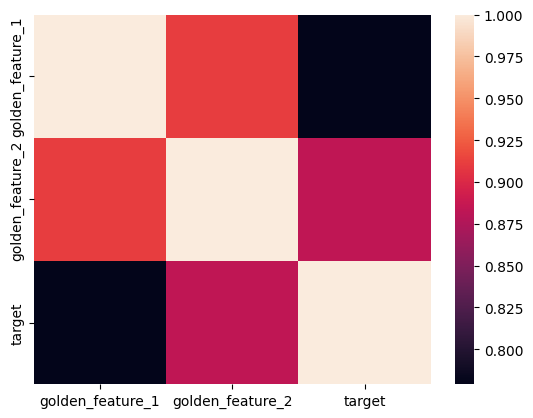

In [4]:
import seaborn as sns
corr = df[['golden_feature_1','golden_feature_2','target']].corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Как видим, обе golgen features сильно скоррелированы между собой и с таргетом (по построению)

### Random Forest

Давайте попробуем обучить RandomForest

Как вы думаете, вот эти сильно скоррелированные между собой и с таргетом фичи где расположатся по важности для модели?

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 20, max_features = 0.5, random_state = random_state)
rf.fit(df.drop('target', axis = 1), y)

RandomForestClassifier(max_depth=20, max_features=0.5, random_state=121)

In [7]:
from tabulate import tabulate
from operator import itemgetter
t = []
for feature, importance in zip(df.drop('target', axis = 1).columns, rf.feature_importances_):
  t.append([feature, importance])
t = sorted(t, reverse = True, key = itemgetter(1))
print(tabulate(t, headers = ['Признак', 'Важность']))

Признак             Важность
----------------  ----------
golden_feature_2  0.607862
feature_2         0.176073
golden_feature_1  0.114753
feature_8         0.0741608
feature_6         0.0101138
feature_5         0.00778537
feature_0         0.00179993
feature_3         0.00170889
feature_7         0.00146428
feature_9         0.00145848
feature_4         0.00143497
feature_1         0.00138557


Неожиданно, правда?      
Или нет?

Сохранится ли такой эффект при изменении max_features?

In [8]:
#INSERT YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from operator import itemgetter

max_features_list = [0.1, 0.3, 0.5, 0.7, 0.9]

for mf in max_features_list:
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        max_features=mf,
        random_state=random_state
    )
    rf.fit(df.drop('target', axis=1), y)

    t = []
    for feature, importance in zip(df.drop('target', axis=1).columns,
                                   rf.feature_importances_):
        t.append([feature, importance])
    t = sorted(t, key=itemgetter(1), reverse=True)

    features_order = [f for f, _ in t]
    rank_gf1 = features_order.index('golden_feature_1') + 1

    print(f"max_features = {mf}")
    print(tabulate(t, headers=["Признак", "Важность"]))
    print(f"Позиция golden_feature_1: {rank_gf1}\n")

max_features = 0.1
Признак             Важность
----------------  ----------
golden_feature_2  0.336537
feature_2         0.193717
feature_8         0.190704
golden_feature_1  0.166116
feature_6         0.0534965
feature_5         0.0275498
feature_9         0.00549981
feature_4         0.00548303
feature_0         0.00545305
feature_1         0.00515579
feature_7         0.00515043
feature_3         0.00513838
Позиция golden_feature_1: 4

max_features = 0.3
Признак             Важность
----------------  ----------
golden_feature_2  0.447428
feature_2         0.201567
feature_8         0.146761
golden_feature_1  0.145571
feature_6         0.0321426
feature_5         0.0145146
feature_0         0.00206754
feature_7         0.00206134
feature_9         0.00203133
feature_3         0.00196937
feature_1         0.00195512
feature_4         0.00193222
Позиция golden_feature_1: 4

max_features = 0.5
Признак             Важность
----------------  ----------
golden_feature_2  0.607862
feature_

**Вопрос для теста** -- на каком месте окажется golden_feature_1 при max_features = 0.9?



1.   втором
2.   третьем
3.   четвертом
4.   пятом
5.   восьмом






Хотя простая корреляционная матрица дает другие числа

In [9]:
df[['golden_feature_1','golden_feature_2','target']].corr()

,golden_feature_1,golden_feature_2,target
golden_feature_1,1.000000,0.910394,0.779165
golden_feature_2,0.910394,1.000000,0.883246
target,0.779165,0.883246,1.000000


Как проверить еще что golden_feature_1 действительно важная?

Обучить RF без ее подруги!


In [10]:
# INSERT YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate
from operator import itemgetter

X_wo_gf2 = df.drop(columns=['target', 'golden_feature_2'])

rf_wo_gf2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    max_features=0.9,
    random_state=random_state
)
rf_wo_gf2.fit(X_wo_gf2, y)

t = []
for feature, importance in zip(X_wo_gf2.columns, rf_wo_gf2.feature_importances_):
    t.append([feature, importance])
t = sorted(t, key=itemgetter(1), reverse=True)

print(tabulate(t, headers=['Признак', 'Важность']))

features_order = [f for f, _ in t]
print("Позиция golden_feature_1:", features_order.index('golden_feature_1') + 1)

Признак             Важность
----------------  ----------
feature_2         0.605594
golden_feature_1  0.215889
feature_8         0.131145
feature_5         0.0130605
feature_6         0.00774722
feature_0         0.00467528
feature_4         0.00464695
feature_9         0.00454185
feature_7         0.00430285
feature_1         0.00422526
feature_3         0.00417155
Позиция golden_feature_1: 2


**Вопрос для теста** -- на каком месте по важности окажется фича golden_feature_1 если обучить Random Forest с max_features = 0.9 на датасете без фичи golden_feature_2?



1.   первом
2.   втором
3.   третьем
4.   четвертом
5.   пятом
6.   восьмом



### Extremal Gradient Boosting

убедимся что в бустинге будет тот же эффект

In [12]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, colsample_bytree = 0.5, random_state = 43)

In [13]:
xgb.fit(df.drop('target', axis = 1), y)
t = []
for feature, importance in zip(df.drop('target', axis = 1).columns, xgb.feature_importances_):
  t.append([feature, importance])
t = sorted(t, reverse = True, key = itemgetter(1))
print(tabulate(t, headers = ['Признак', 'Важность']))

Признак             Важность
----------------  ----------
golden_feature_2  0.619467
feature_2         0.221745
feature_8         0.0638065
golden_feature_1  0.0492883
feature_6         0.0170231
feature_5         0.0134591
feature_9         0.00279441
feature_3         0.0027107
feature_7         0.00263437
feature_4         0.00243511
feature_0         0.00234785
feature_1         0.00228789


Давайте повторим эксперимент аналогично RF

In [14]:
# INSERT YOUR CODE HERE
colsample_list = [0.1, 0.3, 0.5, 0.7, 1.0]

for cs in colsample_list:
    xgb = XGBClassifier(
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        colsample_bytree=cs,
        random_state=43
    )
    xgb.fit(df.drop('target', axis=1), y)

    t = []
    for feature, importance in zip(df.drop('target', axis=1).columns,
                                   xgb.feature_importances_):
        t.append([feature, importance])
    t = sorted(t, reverse=True, key=itemgetter(1))

    features_order = [f for f, _ in t]
    rank_gf1 = features_order.index('golden_feature_1') + 1

    print(f"colsample_bytree = {cs}")
    print(tabulate(t, headers=['Признак', 'Важность']))
    print(f"Позиция golden_feature_1: {rank_gf1}\n")

colsample_bytree = 0.1
Признак              Важность
----------------  -----------
golden_feature_2  0.552883
feature_2         0.159602
feature_8         0.152073
golden_feature_1  0.102299
feature_6         0.0256526
feature_5         0.00285909
feature_9         0.00090864
feature_7         0.000905116
feature_1         0.000789701
feature_0         0.000779286
feature_3         0.000649981
feature_4         0.000598758
Позиция golden_feature_1: 4

colsample_bytree = 0.3
Признак             Важность
----------------  ----------
golden_feature_2  0.471446
feature_2         0.235824
golden_feature_1  0.11758
feature_8         0.106966
feature_6         0.0389796
feature_5         0.0156684
feature_9         0.00260139
feature_7         0.00256862
feature_4         0.00213963
feature_1         0.00213518
feature_3         0.00208827
feature_0         0.002004
Позиция golden_feature_1: 3

colsample_bytree = 0.5
Признак             Важность
----------------  ----------
golden_feature_2  

**Вопрос для теста** -- на каком месте окажется golden_feature_1 при colsample_bytree = 1.0?



1.   втором
2.   третьем
3.   четвертом
4.   пятом
5.   шестом
6.   восьмом

Давайте посмотрим что произойдет без "подруги" -- фичи golden_feature_2

In [15]:
# INSERT YOUR CODE HERE
X_wo_gf2 = df.drop(columns=['target', 'golden_feature_2'])

xgb_wo_gf2 = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    colsample_bytree=1.0,
    random_state=43
)
xgb_wo_gf2.fit(X_wo_gf2, y)

t = []
for feature, importance in zip(X_wo_gf2.columns,
                               xgb_wo_gf2.feature_importances_):
    t.append([feature, importance])
t = sorted(t, reverse=True, key=itemgetter(1))

print(tabulate(t, headers=['Признак', 'Важность']))

features_order = [f for f, _ in t]
print("Позиция golden_feature_1:",
      features_order.index('golden_feature_1') + 1)

Признак             Важность
----------------  ----------
feature_2         0.72251
feature_8         0.11547
golden_feature_1  0.101766
feature_5         0.0138126
feature_6         0.0092117
feature_0         0.00706574
feature_1         0.00642251
feature_3         0.00633196
feature_9         0.00609246
feature_7         0.00598582
feature_4         0.00533143
Позиция golden_feature_1: 3


**Вопрос для теста** -- на каком месте окажется golden_feature_1 при обучении на датасете без golden_feature_2 с параметром colsample_bytree = 1.0?


1.   первом
2.   втором
3.   третьем
4.   четвертом
5.   пятом
6.   восьмом

## Регуляризация

Давайте посмотрим что произойдет если мы с мультиколлинерностью будем бороться классическим приемом -- регуляризацией

In [16]:
for reg_lambda in [0.1, 1, 5, 10, 30, 60, 100, 500, 1000]:
    xgb = XGBClassifier(
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        colsample_bytree=1.0,
        reg_lambda=reg_lambda,
        random_state=43
    )
    X = df.drop('target', axis=1)
    xgb.fit(X, y)

    t = []
    for feature, importance in zip(X.columns, xgb.feature_importances_):
        t.append([feature, importance])
    t = sorted(t, reverse=True, key=itemgetter(1))

    features_order = [f for f, _ in t]
    rank_gf1 = features_order.index('golden_feature_1') + 1

    print(f"reg_lambda = {reg_lambda}")
    print(tabulate(t, headers=['Признак', 'Важность']))
    print(f"Позиция golden_feature_1: {rank_gf1}\n")

reg_lambda = 0.1
Признак             Важность
----------------  ----------
golden_feature_2  0.825583
feature_8         0.0595961
feature_2         0.0518263
feature_5         0.0140957
feature_6         0.00894363
golden_feature_1  0.00685982
feature_3         0.00623336
feature_9         0.00584938
feature_1         0.00578352
feature_0         0.00538566
feature_7         0.00508744
feature_4         0.00475651
Позиция golden_feature_1: 6

reg_lambda = 1
Признак             Важность
----------------  ----------
golden_feature_2  0.835641
feature_8         0.0562887
feature_2         0.055019
feature_5         0.0133256
feature_6         0.00698487
golden_feature_1  0.00582277
feature_3         0.00516934
feature_9         0.00475428
feature_1         0.00455164
feature_0         0.00439369
feature_7         0.00408448
feature_4         0.00396448
Позиция golden_feature_1: 6

reg_lambda = 5
Признак             Важность
----------------  ----------
golden_feature_2  0.853735
feature_2

**Вопрос для теста** -- на каком месте окажется golden_feature_1 при обучении  с параметрами colsample_bytree = 1.0 и reg_lambda = 1000?


1.   первом
2.   втором
3.   третьем
4.   четвертом
5.   пятом
6.   восьмом
7.   десятом

Как менялась важность фичи с ростом коэффицента L2-регуляризации?

____

Вывод который можно сделать -- по возможности проблему мультиколлинеарных фичей решат через feature engineering

**Задание**

Кстати, а в бустинге на что (на какие веса) накладывает ограничения L2-регуляризация?

*   Веса деревьев
*   Веса листьев
*   Веса корней
*   Веса веток
*   Веса белок


веса листьев

Ответ здесь https://arxiv.org/pdf/1603.02754